In [1]:
# 必要なパッケージを呼び出す
import numpy as np
from scipy.optimize import newton
from scipy.interpolate import interp1d # for splines
import matplotlib.pyplot as plt
import japanize_matplotlib
import time

In [2]:
# MATLABではグローバル変数を使って関数への変数受け渡しを行う
# Julia/Pythonではコンストラクタを用いる

# ギリシャ文字の使用は不可とする
class Model:

    def __init__(self,beta,gamma,alpha,delta,kmax,kmin,nk,kgrid):

        # カリブレーション
        self.beta = beta    # 割引因子
        self.gamma = gamma  # 相対的リスク回避度(異時点間の代替弾力性の逆数)
        self.alpha = alpha  # 資本分配率 
        self.delta = delta  # 固定資本減耗
        # グリッドに関するパラメータ
        self.kmax = kmax    # 資本グリッドの最大値
        self.kmin = kmin    # 資本グリッドの最小値
        self.nk = nk        # グリッドの数
        self.kgrid = kgrid  # 資本グリッド

In [3]:
def mu_CRRA(cons, gamma):
        """
        --------------------------------------
        === CRRA Marginal Utility Function ===
        --------------------------------------
        <inputs>
        ・m: パラメータ等を格納したコンストラクタ
        ・cons: 消費量
        <output>
        ・consとgamma の下での限界効用水準
        """
        
        mu = cons ** (-gamma)
        return mu


In [4]:
def EulerEq(cons,m,capital,cnext):
    """
    ----------------------------------------------
    === オイラー方程式に代入した際の残差を返す関数 ===
    ----------------------------------------------
    <input>
    ・cons: 今期の消費水準
    ・m: パラメータ等を格納したコンストラクタ
    ・capital: 今期の資本保有量
    ・cnext: 補間した消費関数
    (※matlabコードでは関数EulerEqで消費関数の補間を行っているが、
    pythonコードでは補間した消費関数を引数で先に与える)
    <output>
    ・res: オイラー方程式に代入した際の残差
    """

    wealth = capital**m.alpha + (1-m.delta)*capital
    
    kprime = wealth - cons
    #トリック:k'は正の値しか取らない
    kprime = max(m.kgrid[0],kprime) 

    # Pythonでは補間は関数linearp1dで行う（メインファイル）
    # cnext(kprime)がk'で評価したc'の値

    # オイラー方程式の残差を求める（u'(c)をmu_CRRA関数を用いて計算している）
    res = mu_CRRA(cons,m.gamma) - m.beta*mu_CRRA(cnext(kprime),m.gamma)*(m.alpha*kprime**(m.alpha-1.0) + (1.0-m.delta))

    return res

In [5]:
# カリブレーション
beta = 0.96 # 割引因子
gamma = 1.0  # 相対的危険回避度(異時点間の代替の弾力性の逆数)
alpha = 0.40 # 資本分配率
delta = 1.0  # 固定資本減耗(delta=1.0のときは解析解が存在)

# 定常状態の値
ykss = (1.0/beta-1.0+delta)/alpha
kss = ykss**(1.0/(alpha-1.0))
yss = ykss*kss
css = yss-delta*kss

kmax = 0.5  # 資本グリッドの最大値
kmin = 0.05 # 資本グリッドの最小値 (0にすると生産が出来なくなる)
#========================#

## STEP 1(a): グリッド生成
nk = 21     # グリッドの数
kgrid = np.linspace(kmin,kmax,nk)

maxiter = 1000 # 繰り返し計算の最大値
tol = 1e-5     # 許容誤差(STEP2)

# Julia/Python: コンストラクタにパラメータを格納
m = Model(beta,gamma,alpha,delta,kmax,kmin,nk,kgrid)

In [7]:
# 収束の基準に関するパラメータ
it = 1    # ループ・カウンター
dif2 = 1.0 # 政策関数の繰り返し誤差
tolfun = 1e-10 # newtonのオプション(最適化の許容誤差)

start = time.time()

print("")
print("-+- Solve a neoclassical growth model with time iteration -+-")
print("")

## STEP 1(b): 政策関数の初期値を当て推量 
cfcn0 = m.kgrid
cfcn1 = np.zeros(m.nk)

# 繰り返し誤差を保存する変数を設定 
dif = np.zeros((2,maxiter))

## STEP 4: 政策関数を繰り返し計算
while (it < maxiter) & (dif2 > tol):

    # Pythonでは補間は関数interp1dで行う
    # cnext(kprime)がk'で評価したc'の値
    # 次期の政策関数を線形補間
    cnext = interp1d(m.kgrid,cfcn0,kind="linear",fill_value="extrapolate")
    # 次期の価値関数をスプライン補間
    # interp_c = interp1d(m.kgrid,cfcn0,kind="cubic",fill_value="extrapolate")

    for i in range(m.nk):

        capital = m.kgrid[i]
        wealth = (capital**m.alpha) + (1.0-m.delta)*capital

        # Pythonの最適化関数(newton)を使って各グリッド上の政策関数の値を探す
        # オイラー方程式の誤差をゼロにするようなcの値を求める
        Euler = lambda x: EulerEq(x,m,capital,cnext)
        # 最適化の初期値は古い政策関数の値
        cons = newton(Euler,x0=cfcn0[i],tol=tolfun)
        cfcn1[i] = cons
        kprime = wealth-cons
        # グリッドごとに最適化の結果を確認
        #println([cons capital wealth kprime])
        #pause

    # 繰り返し計算誤差を確認
    dif2 = np.max(np.abs(cfcn1-cfcn0))
    
    # 収束途中の繰り返し計算誤差を保存
    dif[1,it] = dif2

    # 政策関数をアップデート
    # Pythonで配列の代入はポインタ渡しのため、copyコマンドが必要
    # cfcn0 = cfcn1とすると、cfcn1の値を変更すると同時にcfcn0の値も変更されてしまう
    cfcn0 = np.copy(cfcn1)

    # 繰り返しの結果を表示
    print(f"iteration index: {it}")
    print(f"policy function iteration error: {dif2}")

    it += 1 


end = time.time() - start
print("")
print(f"running time is {end:.5f}")
print("")


-+- Solve a neoclassical growth model with time iteration -+-

iteration index: 1
policy function iteration error: 0.09823124494179636
iteration index: 2
policy function iteration error: 0.0316374442575135
iteration index: 3
policy function iteration error: 0.011354344655405302
iteration index: 4
policy function iteration error: 0.005518482419654525
iteration index: 5
policy function iteration error: 0.0023193411971422218
iteration index: 6
policy function iteration error: 0.0009234569926682146
iteration index: 7
policy function iteration error: 0.00036240485611988005
iteration index: 8
policy function iteration error: 0.0001396588273769317
iteration index: 9
policy function iteration error: 5.345424767294604e-05
iteration index: 10
policy function iteration error: 2.0415713933907842e-05
iteration index: 11
policy function iteration error: 7.795027961998713e-06

running time is 0.18400



In [8]:
## 最終的な政策関数が得られてから貯蓄関数を計算
pfcn0 =  (m.kgrid**m.alpha) + (1.0-m.delta)*m.kgrid - cfcn0 

## 解析的解(for k'=g(k))
p_true = m.beta*m.alpha*(m.kgrid**m.alpha)

mu_CRRA_vec = np.vectorize(mu_CRRA)

## オイラー方程式から誤差を測定
# 元のグリッドではオイラー方程式の誤差はゼロになるため、グリッドを細かくとる
kgrid_err = np.linspace(m.kmin,m.kmax,(m.nk-1)*10+1)
# Pythonでは補間は関数interp1dで行う
# cons_interp(kp)がk'で評価したc'の値
cons_interp = interp1d(m.kgrid,cfcn0,kind="linear",fill_value="extrapolate")
# c=h(k;b)の値を線形補間
cons = cons_interp(kgrid_err)
LHS = mu_CRRA_vec(cons,m.gamma)

# k'=f(k)-c
kp = (kgrid_err**m.alpha) + (1.0-m.delta)*kgrid_err - cons
# c'=h(k';b)の値を線形補間
cnext = cons_interp(kp)
rent = m.alpha*(kp**(m.alpha-1.0)) - m.delta
RHS = m.beta*(1.0+rent) * mu_CRRA_vec(cnext,m.gamma)

err = (RHS/LHS)-1.0

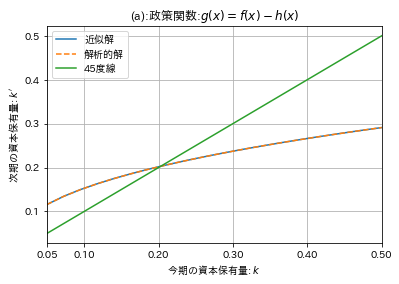

In [9]:
fig, ax = plt.subplots()
ax.plot(m.kgrid,pfcn0,label="近似解")
ax.plot(m.kgrid,p_true,ls="--",label="解析的解")
ax.plot(m.kgrid,m.kgrid,label="45度線")
ax.set(xlabel=r"今期の資本保有量: $k$",ylabel=r"次期の資本保有量: $k'$",title=r"(a):政策関数:$g(x)=f(x)-h(x)$",
xlim=(m.kmin,m.kmax),xticks=[0.05,0.1,0.2,0.3,0.4,0.5])
ax.legend(loc="upper left")
ax.grid()
plt.show()

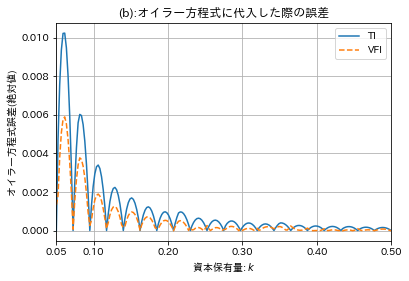

In [10]:
f = open("err_ndp.csv",encoding='utf-8-sig')
err2 = np.loadtxt(f) #VFIでのオイラー方程式誤差

fig, ax = plt.subplots()
ax.plot(kgrid_err,np.abs(err),label="TI")
ax.plot(kgrid_err,np.abs(err2),ls="--",label="VFI")
ax.set(xlabel=r"資本保有量: $k$",ylabel="オイラー方程式誤差(絶対値)",title="(b):オイラー方程式に代入した際の誤差",
xlim=(m.kmin,m.kmax),xticks=[0.05,0.1,0.2,0.3,0.4,0.5])
ax.legend(loc="upper right")
ax.grid()
plt.show()